In [2]:
import pandas as pd
from utils import utils
from models import models
from tensorflow import keras

In [2]:
CONFIG_YML = "../experiments/exp_007/config_007.yml"
WEIGHTS = "../experiments/exp_007/model.04-1.1565.h5"

In [8]:
config = utils.load_config(CONFIG_YML)
config

{'seed': 123,
 'data': {'train_df': '/home/app/src/data/train_df_zoom.csv',
  'val_df': '/home/app/src/data/val_df.csv',
  'test_df': '/home/app/src/data/test_df.csv'},
 'model': {'weights': 'imagenet',
  'classes_movement': 4,
  'classes_scale': 5,
  'dropout_rate': 0.5,
  'image_size': 224,
  'channels': 3,
  'batch_size': 8,
  'frames': 8,
  'trainable_layers': 'None'},
 'compile': {'optimizer': {'adam': {'learning_rate': 0.0001}},
  'loss': 'sparse_categorical_crossentropy',
  'metrics': ['accuracy']},
 'fit': {'epochs': 20,
  'callbacks': {'model_checkpoint': {'filepath': '../experiments/exp_007/model.{epoch:02d}-{val_loss:.4f}.h5',
    'save_best_only': True,
    'verbose': 1},
   'tensor_board': {'log_dir': '../experiments/exp_007/logs'},
   'reduce_on_plateau': {'verbose': 1, 'patience': 2}}}}

In [9]:
MODEL_CLASSES_MOVEMENT,MODEL_CLASSES_SCALE = utils.get_class_names(config)

if len(MODEL_CLASSES_MOVEMENT) != config['model']['classes_movement']:
    raise ValueError(
        "Number of classes doesn't match between your model "
        "and your data!"
    )
    
if len(MODEL_CLASSES_SCALE) != config['model']['classes_scale']:
    raise ValueError(
        "Number of classes doesn't match between your model "
        "and your data!"
    )


In [10]:
test_df=pd.read_csv(config["data"]["test_df"],index_col='Unnamed: 0')

test_generator = models.DataGenerator(test_df, config['model']['batch_size'], output = 'movement')

In [11]:
test_df

,scale,movement,ubication,lenght_frames,frames_per_second,duration,inversed
0,LS,Static,../data/data_cleaned/test/tt2006051_shot_0009.mp4,108,24.000000,4.500000,no
1,MS,Static,../data/data_cleaned/test/tt2006051_shot_0010.mp4,70,24.000000,2.916667,no
2,MS,Static,../data/data_cleaned/test/tt2006051_shot_0020.mp4,31,24.000000,1.291667,no
3,LS,Static,../data/data_cleaned/test/tt2006051_shot_0022.mp4,365,24.000000,15.208333,no
4,FS,Motion,../data/data_cleaned/test/tt2006051_shot_0026.mp4,77,24.000000,3.208333,no
...,...,...,...,...,...,...,...
8182,FS,Static,../data/data_cleaned/test/tt6644200_shot_0011.mp4,26,23.976024,1.084417,no
8183,MS,Motion,../data/data_cleaned/test/tt6644200_shot_0015.mp4,38,23.976024,1.584917,no
8184,FS,Motion,../data/data_cleaned/test/tt6644200_shot_0021.mp4,47,23.976024,1.960292,no
8185,LS,Static,../data/data_cleaned/test/tt6644200_shot_0026.mp4,28,23.976024,1.167833,no


In [12]:
model=keras.models.load_model(WEIGHTS, compile=False)

# It should print your model correctly
print(model.summary())

2022-07-23 16:40:11.004974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:40:11.015314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:40:11.016145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 16:40:11.018384: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 2048)          23587712  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 8, 128)            1114624   
                                                                 
 lstm_1 (LSTM)               (None, 16)                9280      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [14]:
probabilities=model.predict(test_generator,verbose=1)

1024/1024 [==============================] - 1793s 2s/step


In [15]:
predictions_movement=[]

for prediction in probabilities:
    index_max=prediction.argmax()
    predictions_movement.append(MODEL_CLASSES_MOVEMENT[index_max])

In [16]:
labels_movement=test_df["movement"].values.tolist()
if len(set(predictions_movement)) != len(set(labels_movement)):
    raise ValueError(
        "The lenght of predictions and labels lists doesn't match!"
    )

if not isinstance(predictions_movement[0], str):
    raise ValueError(
        "Model predictions should be represented as string. E.g: 'Static'"
    )

if not isinstance(labels_movement[0], str):
    raise ValueError(
        "Ground true labels should be represented as string. E.g: 'Static'"
    )

Movement results
Model Performance metrics:
------------------------------
Accuracy: 0.5324
Macro Average Precision: 0.3405
Macro Average Recall: 0.3816
Macro Average F1 Score: 0.3205

Model Classification report:
------------------------------
              precision    recall  f1-score   support

      Motion       0.47      0.58      0.52      2423
        Pull       0.02      0.21      0.04        80
        Push       0.05      0.20      0.08       220
      Static       0.82      0.53      0.64      5463

    accuracy                           0.53      8186
   macro avg       0.34      0.38      0.32      8186
weighted avg       0.69      0.53      0.59      8186


Prediction Confusion Matrix:
------------------------------


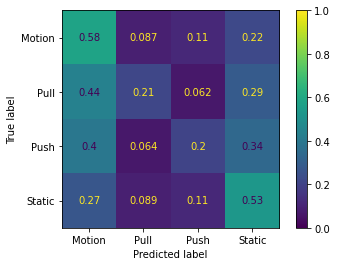

In [11]:
print('Movement results')

accuracy, precision, recall, f1_score=utils.get_performance(predictions_movement,labels_movement,MODEL_CLASSES_MOVEMENT)